# Model-9

In [1]:
import tensorflow as tf
import numpy as np
from timeit import default_timer as timer
from dataset import Dataset
from layers import *
from networks import *
from model import Model
from dbase import DataBase
from visualisation import show_similarity

In [2]:
tr_data_path = "/netforge/datasets/private/roman/coins/2017-11-29/datasets/train/5557_300_128_128_1_uint8_aug2.npy"
va_data_path = "/netforge/datasets/private/roman/coins/2017-11-29/datasets/valid/550_300_128_128_1_uint8_aug2.npy"

model_path   = "models/009/"

## Dataset

In [3]:
%%time
tr_dataset   = Dataset(tr_data_path)
va_dataset   = Dataset(va_data_path)
tr_dataset.load()
va_dataset.load()
image_shape  = list(tr_dataset.data.shape[-3:])
print("Train:", list(tr_dataset.data.shape), tr_dataset.data.dtype)
print("Valid:", list(va_dataset.data.shape), va_dataset.data.dtype)
print('-'*50)

Train: [5557, 300, 128, 128, 1] uint8
Valid: [550, 300, 128, 128, 1] uint8
--------------------------------------------------
CPU times: user 316 ms, sys: 1min 20s, total: 1min 20s
Wall time: 2min 31s


## Build 

In [ ]:
def simple_conv(images, out_dim, reuse, training):
    with tf.variable_scope("simple_conv", reuse=reuse):
        l = batch_norm(images, training) # -> 128

        l = conv2d_maxpool(l,  16) # -> 64
        l = conv2d_maxpool(l,  32) # -> 32
        l = conv2d_maxpool(l,  64) # -> 16
        l = conv2d_maxpool(l, 128) # -> 8
        l = conv2d_maxpool(l, 256) # -> 4

        l = flatten(l)             # -> 1024

        l = dense(l,    1024)
        l = dense(l,    1024)
        l = dense(l, out_dim)
        
        l = normalize(l)
        
        return l

In [4]:
%%time
out_dims       = 300
margin         = .2
acc_batch_size = 300
network        = simple_conv

model = Model(image_shape, out_dims, acc_batch_size)
model.build(network)

CPU times: user 4.72 s, sys: 964 ms, total: 5.69 s
Wall time: 6.61 s


In [6]:
%%time
accs = []
for i in range(1):
    acc = model.calc_acc(tr_dataset)
    accs.append(acc)
acc = np.mean(accs)
print("Acc: %.1f%%" % (acc*100))

Acc: 82.3%
CPU times: user 1.45 s, sys: 924 ms, total: 2.38 s
Wall time: 2.87 s


## Train

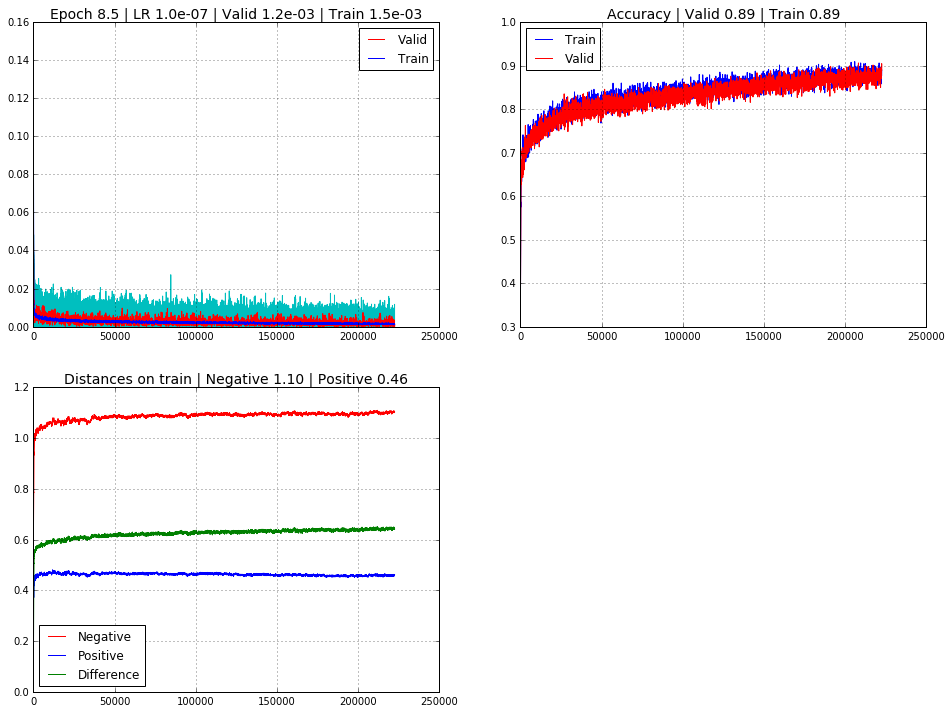

--------------------------------------------------
CPU times: user 21min 13s, sys: 2min 56s, total: 24min 10s
Wall time: 22min 26s


In [120]:
%%time
model.train(
    step_num   = 300000, 
    batch_size = 64,
    lr         = {1:1e-4, 0.02:3e-5, 0.01:1e-5, 7e-3:3e-6, 5e-3:1e-6, 3e-3:3e-7, 1.5e-3:1e-7}, 
    log_every  = 30,
    tr_dataset = tr_dataset,
    va_dataset = va_dataset,
    margin     = margin,
    log_scale  = False)

model.save(model_path)
print('-'*50)

## Database

In [112]:
%%time
ethalons  = tr_dataset.get_ethalons()
augmented = tr_dataset.get_augmented() # get_augmented() get_ethalons()

dbase     = DataBase()
dbase.build(model, ethalons)
print("Ethalons :", list(ethalons.shape),  ethalons.dtype)
print("Augmented:", list(augmented.shape), augmented.dtype)
print('-'*50)

Ethalons : [5557, 128, 128, 1] float32
Augmented: [5557, 128, 128, 1] float32
--------------------------------------------------
CPU times: user 1.34 s, sys: 2.69 s, total: 4.03 s
Wall time: 3.94 s


## Accuracy

In [113]:
%%time
def accuracy(ind, k):
    assert 0 < k <= ind.shape[1]
    err = 0
    N   = len(ind)
    for i in range(N):
        ok = False
        for j in range(k):
            if i==ind[i,j]:
                ok = True
        err+= not ok
    return ((N-err)/N*100)

start = timer()
ind, dist = dbase.query(augmented, 3)
t = timer() - start
n = augmented.shape[0]

print("Database   : %s" % list(dbase.embeds.shape))
print("Request    : %s" % list(augmented.shape))
print("Performance: %.0f img/sec" % (n/t))
print('-'*50)
for k in range(1, ind.shape[1]+1):
    print("Accuracy@%d: %.1f%%" % (k, accuracy(ind, k)))
print('-'*50)

Database   : [5557, 300]
Request    : [5557, 128, 128, 1]
Performance: 332 img/sec
--------------------------------------------------
Accuracy@1: 82.1%
Accuracy@2: 89.0%
Accuracy@3: 91.7%
--------------------------------------------------
CPU times: user 16.8 s, sys: 204 ms, total: 17.1 s
Wall time: 16.7 s


## Search

Average distance: 0.38


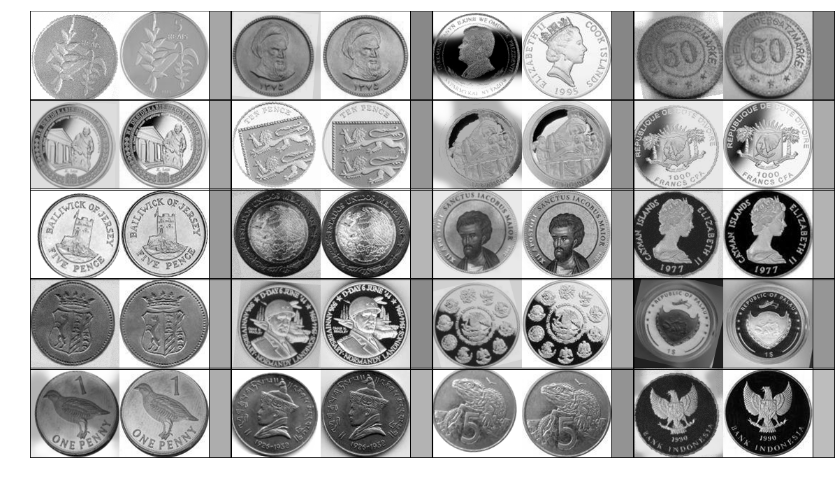

In [118]:
def search(request, max_k=0):
    num = 20
    per = np.random.choice(range(len(request)), num, replace=False)
    request  = request[per]
    ethalons = dbase.images
    ind, dist  = dbase.query(request, 3)
    for k in range(0, max_k+1):
        print("Average distance: %.2f" % np.mean(dist[:,k]))
        im2 = ethalons[ind[:,k]]
        sim = 1-dist[:,k]
        show_similarity(request, im2, sim, cols=4)

search(augmented)

## Restore

In [5]:
%time
model.restore(model_path)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs
INFO:tensorflow:Restoring parameters from models/009/
